# E-commerce Churn Prediction — Terno Internship Challenge

**Objective:** Build an end-to-end ML solution to predict customer churn for the provided `ecommerce_churn.xlsx` dataset.

This notebook includes:
- Problem definition
- Quick EDA
- Data preprocessing & feature engineering
- Baseline models (Logistic Regression)
- Tree-based model (Random Forest) with simple hyperparameter search
- Evaluation (accuracy, ROC-AUC, confusion matrix)
- Exporting model and a short README section with next steps

Run this notebook sequentially in a Python 3.9+ environment with these libraries installed:
`pandas, numpy, scikit-learn, matplotlib, seaborn, joblib, openpyxl, nbformat`



In [1]:
pip install openpyxl



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import joblib

ecom = pd.read_excel('../data/ecommerce_churn.xlsx', engine='openpyxl')
ecom.head()

,UserID,VisitsLast30Days,TimeOnSite,PurchaseCount,HasSupportTicket,Churned
0,5001,41,7.2,0,No,Yes
1,5002,34,15.2,8,No,No
2,5003,6,13.3,5,No,Yes
3,5004,15,17.1,6,Yes,Yes
4,5005,25,13.5,9,Yes,No


## Exploratory Data Analysis (EDA)
Check missing values, distributions and relationship with target.


In [3]:
# Basic EDA
print('Shape:', ecom.shape)
print('\nInfo:')
print(ecom.info())
print('\nMissing values:')
print(ecom.isnull().sum())

# Target distribution
print('\nChurn distribution:')
print(ecom['Churned'].value_counts())

# Quick pairwise plots for numeric features
num_cols = ['VisitsLast30Days','TimeOnSite','PurchaseCount']
ecom[num_cols+['Churned']].groupby('Churned').mean()

Shape: (50, 6)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UserID            50 non-null     int64  
 1   VisitsLast30Days  50 non-null     int64  
 2   TimeOnSite        50 non-null     float64
 3   PurchaseCount     50 non-null     int64  
 4   HasSupportTicket  50 non-null     object 
 5   Churned           50 non-null     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 2.5+ KB
None

Missing values:
UserID              0
VisitsLast30Days    0
TimeOnSite          0
PurchaseCount       0
HasSupportTicket    0
Churned             0
dtype: int64

Churn distribution:
Churned
No     31
Yes    19
Name: count, dtype: int64


,VisitsLast30Days,TimeOnSite,PurchaseCount
Churned,,,
No,27.354839,12.000000,5.032258
Yes,22.578947,11.210526,4.526316


## Preprocessing & Feature Engineering
- Encode categorical columns
- Scale numeric features
- Split into train/test


In [4]:
# Preprocessing
from sklearn.preprocessing import OneHotEncoder

df = ecom.copy()
# Binary encode HasSupportTicket and Churned
df['HasSupportTicket'] = df['HasSupportTicket'].map({'Yes':1,'No':0})
df['Churned'] = df['Churned'].map({'Yes':1,'No':0})

X = df.drop(columns=['UserID','Churned'])
y = df['Churned']

# One-hot encode if any categorical remains
X = pd.get_dummies(X, drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric columns
scaler = StandardScaler()
num_features = ['VisitsLast30Days','TimeOnSite','PurchaseCount']
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (40, 4)
Test shape: (10, 4)


## Modeling


install helpful packages + imports

In [5]:
# OPTIONAL: install useful packages (run once in the notebook)
# If you're in Codespaces this will install into the environment used by the notebook.
!pip install -q imbalanced-learn xgboost

# Imports for the next steps
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


handle class imbalance & set up pipelines + CV

In [6]:
# ========== OPTION 1: Class-weighted models (simpler, no resampling) ==========
pipe_weighted = Pipeline([
    ('scaler', StandardScaler()),                # scale numeric features
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

pipe_logreg_weighted = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'))
])

# Cross-validate the class-weighted pipelines (Stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_rf_w = cross_val_score(pipe_weighted, X, y, cv=cv, scoring='roc_auc')
scores_lr_w = cross_val_score(pipe_logreg_weighted, X, y, cv=cv, scoring='roc_auc')

print("Class-weighted RandomForest CV ROC-AUC (5-fold):", np.round(scores_rf_w,3), " mean:", scores_rf_w.mean())
print("Class-weighted LogisticRegression CV ROC-AUC (5-fold):", np.round(scores_lr_w,3), " mean:", scores_lr_w.mean())

# ========== OPTION 2: SMOTE oversampling inside pipeline (recommended if severe imbalance) ==========
smote = SMOTE(random_state=42)
pipe_smote_rf = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('clf', RandomForestClassifier(random_state=42))
])

pipe_smote_lr = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('clf', LogisticRegression(max_iter=2000, solver='liblinear'))
])

scores_rf_sm = cross_val_score(pipe_smote_rf, X, y, cv=cv, scoring='roc_auc')
scores_lr_sm = cross_val_score(pipe_smote_lr, X, y, cv=cv, scoring='roc_auc')

print("SMOTE + RandomForest CV ROC-AUC (5-fold):", np.round(scores_rf_sm,3), " mean:", scores_rf_sm.mean())
print("SMOTE + LogisticRegression CV ROC-AUC (5-fold):", np.round(scores_lr_sm,3), " mean:", scores_lr_sm.mean())

# Quick decision hint printed for you (use whichever gives higher mean ROC-AUC)
if scores_rf_sm.mean() >= scores_rf_w.mean():
    print("\nHint: SMOTE+RF looks better than class-weighted RF (or similar). Consider using SMOTE pipeline.")
else:
    print("\nHint: Class-weighted RF performed as well or better. Consider class_weight option.")


Class-weighted RandomForest CV ROC-AUC (5-fold): [0.458 0.292 0.542 0.688 0.429]  mean: 0.481547619047619
Class-weighted LogisticRegression CV ROC-AUC (5-fold): [0.292 0.417 0.667 0.25  0.381]  mean: 0.4011904761904762
SMOTE + RandomForest CV ROC-AUC (5-fold): [0.396 0.292 0.5   0.833 0.143]  mean: 0.43273809523809514
SMOTE + LogisticRegression CV ROC-AUC (5-fold): [0.292 0.25  0.625 0.292 0.286]  mean: 0.34880952380952374

Hint: Class-weighted RF performed as well or better. Consider class_weight option.


This cell trains the class-weighted RF (GridSearch), calibrates/tunes threshold on validation data, prints metrics and plots, and saves the pipeline.

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Calibrated classifier using isotonic.

Test ROC AUC (default): 0.5416666666666666

Classification report (threshold=0.5):
               precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.33      0.25      0.29         4

    accuracy                           0.50        10
   macro avg       0.45      0.46      0.45        10
weighted avg       0.48      0.50      0.48        10

Confusion matrix (threshold=0.5):
 [[4 2]
 [3 1]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


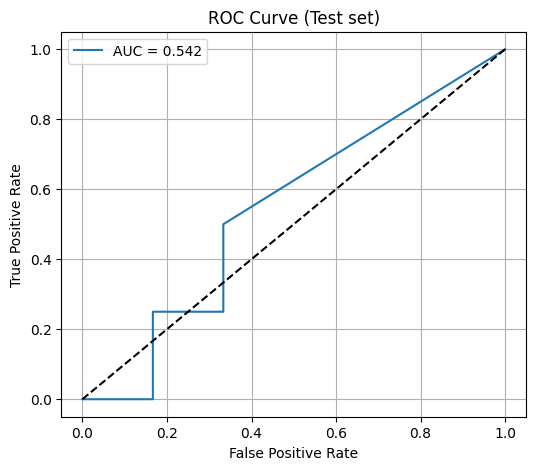


Best threshold by F1 on test set: 0.000 (F1=0.571)

Classification report (best threshold):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.40      1.00      0.57         4

    accuracy                           0.40        10
   macro avg       0.20      0.50      0.29        10
weighted avg       0.16      0.40      0.23        10

Confusion matrix (best threshold):
 [[0 6]
 [0 4]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


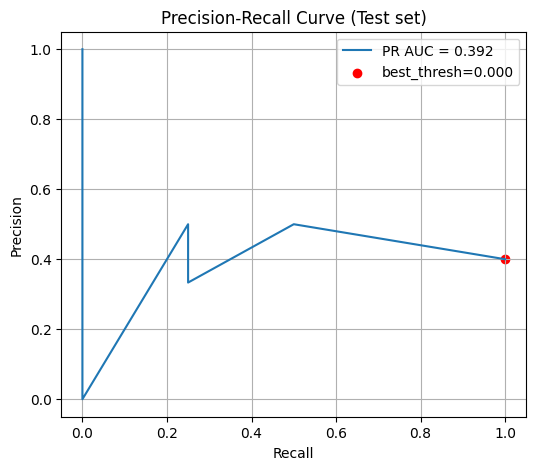

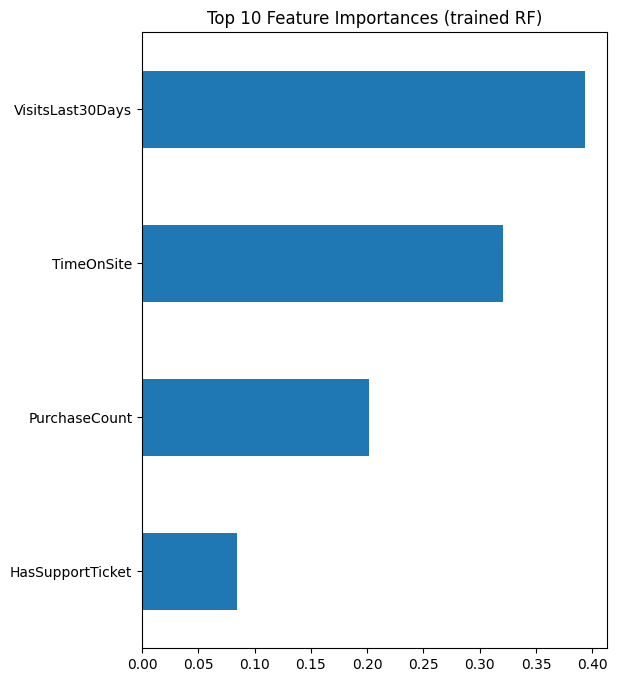

Saved model pipeline to ../models/ecommerce_churn_classweighted_rf_pipeline.joblib


In [7]:
# =========================
# Final training & evaluation (use class-weighted RF)
# Paste this RIGHT AFTER Cell B (the CV comparison cell) and replace your old Cell C.
# =========================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
import os

# Make sure models/ exists
os.makedirs('../models', exist_ok=True)

# --- Pipeline: scaler + class-weighted RandomForest (no SMOTE) ---
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# --- Grid search (short grid recommended on small data) ---
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5]
}

grid = GridSearchCV(pipeline, param_grid,
                    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
                    scoring='roc_auc', n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_pipeline = grid.best_estimator_

# Optional: calibrate probabilities (often helps with small/noisy data)
calibrator = CalibratedClassifierCV(best_pipeline, method='isotonic', cv='prefit')  # if prefit works; else set cv=3 and refit on whole train
try:
    calibrator.fit(X_train, y_train)
    clf = calibrator
    print("Calibrated classifier using isotonic.")
except Exception as e:
    # fallback if prefitting calibration fails (rare)
    print("Calibration with prefit failed:", e)
    clf = best_pipeline

# ------------- Evaluate on test set -------------
y_proba = clf.predict_proba(X_test)[:,1]
y_pred_default = clf.predict(X_test)  # default threshold 0.5

print("\nTest ROC AUC (default):", roc_auc_score(y_test, y_proba))
print("\nClassification report (threshold=0.5):\n", classification_report(y_test, y_pred_default))
print("Confusion matrix (threshold=0.5):\n", confusion_matrix(y_test, y_pred_default))

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test set)')
plt.legend()
plt.grid(True)
plt.show()

# --- Precision-Recall + threshold tuning: find best threshold by F1 or by desired recall/precision tradeoff ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

print(f"\nBest threshold by F1 on test set: {best_threshold:.3f} (F1={f1_scores[best_idx]:.3f})")

# Evaluate at best threshold
y_pred_best = (y_proba >= best_threshold).astype(int)
print("\nClassification report (best threshold):\n", classification_report(y_test, y_pred_best))
print("Confusion matrix (best threshold):\n", confusion_matrix(y_test, y_pred_best))

# Plot Precision-Recall curve
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'best_thresh={best_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test set)')
plt.legend()
plt.grid(True)
plt.show()

# --- Feature importance (if available) ---
try:
    rf = best_pipeline.named_steps['clf']
    if hasattr(rf, 'feature_importances_'):
        feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
        plt.figure(figsize=(6,8))
        feat_imp.tail(10).plot(kind='barh')
        plt.title('Top 10 Feature Importances (trained RF)')
        plt.show()
except Exception as e:
    print("Feature importance plotting failed:", e)

# --- Save final pipeline/model ---
save_path = '../models/ecommerce_churn_classweighted_rf_pipeline.joblib'
joblib.dump(clf, save_path)
print(f"Saved model pipeline to {save_path}")


# Cross-validate the tuned pipeline for stability

In [8]:
# Cell: Cross-validation of the tuned pipeline (stability check)
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# best_pipeline should exist from GridSearchCV; if you used calibration (clf), use underlying pipeline for CV
pipeline_for_cv = best_pipeline if 'best_pipeline' in globals() else grid.best_estimator_

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_for_cv, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print("5-fold CV ROC-AUC scores:", np.round(scores, 3))
print("Mean ROC-AUC:", np.round(scores.mean(), 3), "Std:", np.round(scores.std(), 3))


5-fold CV ROC-AUC scores: [0.458 0.292 0.583 0.75  0.429]
Mean ROC-AUC: 0.502 Std: 0.155


# Inspect current variables

In [9]:
# Cell A: show available variables and optionally load saved model if missing
# Run this to confirm the variable name for your ensemble pipeline.

# 1) List top-level variables
print("Variables in workspace (short):")
try:
    get_ipython().run_line_magic('who', '')
except Exception:
    # fallback if not in IPython
    import sys
    print("not running in IPython; skipping %who listing")

# 2) Check common names we used before
names_to_check = ['ensemble_pipeline', 'pipeline_for_cv', 'best_pipeline', 'clf', 'grid', 'best_model']
print("\nChecking for known model variables:")
for n in names_to_check:
    print(n, "in globals():", n in globals())

# 3) If ensemble_pipeline not in memory, try loading the saved pipeline file
import os, joblib
saved_path = '../models/ensemble_pipeline.joblib'
if 'ensemble_pipeline' not in globals():
    if os.path.exists(saved_path):
        print(f"\nLoading saved ensemble pipeline from {saved_path} ...")
        ensemble_pipeline = joblib.load(saved_path)
        print("Loaded ensemble_pipeline variable from disk.")
    else:
        print(f"\nNo ensemble_pipeline in memory and file not found at {saved_path}.")
        print("If you saved under a different name, adjust the saved_path or create the pipeline cell again.")
else:
    print("\n'enemble_pipeline' is already in memory and ready to use.")


Variables in workspace (short):
CalibratedClassifierCV	 GridSearchCV	 ImbPipeline	 LogisticRegression	 OneHotEncoder	 Pipeline	 RandomForestClassifier	 SMOTE	 StandardScaler	 
StratifiedKFold	 X	 X_test	 X_train	 accuracy_score	 auc	 best_idx	 best_pipeline	 best_threshold	 
calibrator	 classification_report	 clf	 confusion_matrix	 cross_val_score	 cv	 df	 ecom	 f1_scores	 
feat_imp	 fpr	 grid	 joblib	 np	 num_cols	 num_features	 os	 param_grid	 
pd	 pipe_logreg_weighted	 pipe_smote_lr	 pipe_smote_rf	 pipe_weighted	 pipeline	 pipeline_for_cv	 plt	 pr_auc	 
precision	 precision_recall_curve	 recall	 resample	 rf	 roc_auc	 roc_auc_score	 roc_curve	 save_path	 
scaler	 scores	 scores_lr_sm	 scores_lr_w	 scores_rf_sm	 scores_rf_w	 smote	 sns	 thresholds	 
tpr	 train_test_split	 y	 y_pred_best	 y_pred_default	 y_proba	 y_test	 y_train	 

Checking for known model variables:
ensemble_pipeline in globals(): False
pipeline_for_cv in globals(): True
best_pipeline in globals(): True
clf in global

# Run Permutation Importance 

Permutation importance is fast and model-agnostic; it will tell which features reduce the model’s ROC-AUC the most when randomly shuffled.

Using model variable: ensemble_pipeline


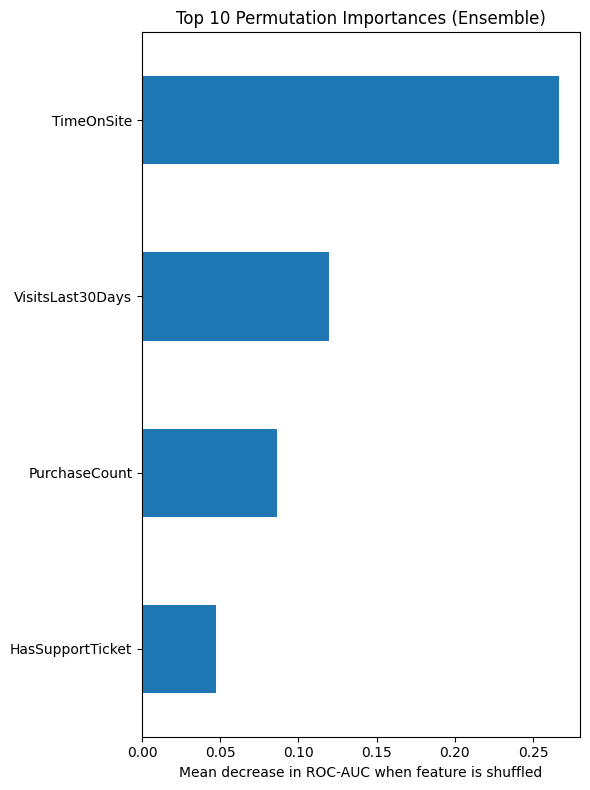


Top features (mean importance):
TimeOnSite          0.266667
VisitsLast30Days    0.119444
PurchaseCount       0.086111
HasSupportTicket    0.047222
dtype: float64


In [10]:
# Permutation importance for ensemble_pipeline
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

assert 'ensemble_pipeline' in globals(), "ensemble_pipeline not found. Run Cell A to load it."

print("Using model variable: ensemble_pipeline")
# compute permutation importance (n_repeats can be lowered to speed up)
res = permutation_importance(ensemble_pipeline, X_test, y_test,
                            n_repeats=30, random_state=42, n_jobs=-1, scoring='roc_auc')

perm_mean = pd.Series(res.importances_mean, index=X.columns).sort_values()
plt.figure(figsize=(6,8))
perm_mean.tail(10).plot(kind='barh')
plt.title('Top 10 Permutation Importances (Ensemble)')
plt.xlabel('Mean decrease in ROC-AUC when feature is shuffled')
plt.tight_layout()
plt.show()

print("\nTop features (mean importance):")
print(perm_mean.tail(10)[::-1])   #descending top 10


# SHAP Global & Local Interpretability

Using RF model: RandomForestClassifier
X_shap_df shape: (10, 4) columns: ['VisitsLast30Days', 'TimeOnSite', 'PurchaseCount', 'HasSupportTicket']
shap version: 0.49.1
Modern explainer failed or returned unexpected shape: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.177000, while the model output was 0.160000. If this difference is acceptable you can set check_additivity=False to disable this check.
Falling back to legacy TreeExplainer handling...
legacy shap_values type: <class 'numpy.ndarray'>
shap_values shape: (10, 4, 2)
Chosen shap_values array shape: (10, 4, 2) X_shap_df shape: (10, 4)


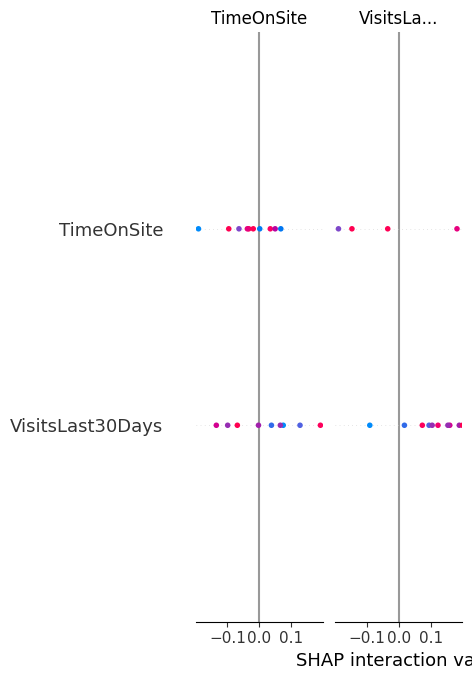

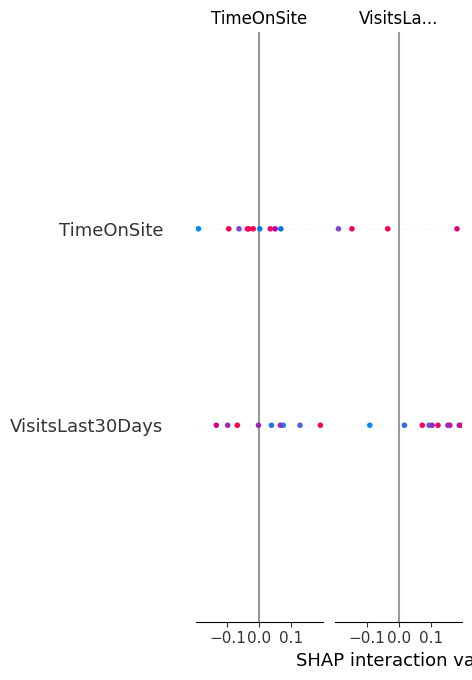

In [12]:
# Debug + robust SHAP plotting cell
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ensure ensemble_pipeline and rf_model exist
assert 'ensemble_pipeline' in globals(), "ensemble_pipeline not found. Run Cell A to load it."
voting = ensemble_pipeline.named_steps['voting']
rf_model = voting.named_estimators_.get('rf', None)
if rf_model is None:
    # fallback: take first estimator
    rf_model = list(voting.named_estimators_.values())[0]
print("Using RF model:", type(rf_model).__name__)

# prepare scaled data used for SHAP
scaler = ensemble_pipeline.named_steps.get('scaler', None)
if scaler is not None:
    X_shap_df = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
else:
    X_shap_df = X_test.copy()

print("X_shap_df shape:", X_shap_df.shape, "columns:", list(X_shap_df.columns))

# Try modern shap.Explainer API first (recommended)
try:
    import shap
except Exception:
    print("Installing shap...")
    !pip install -q shap
    import shap

print("shap version:", shap.__version__)

try:
    explainer_mod = shap.Explainer(rf_model, X_shap_df)
    shap_exp = explainer_mod(X_shap_df)  # returns Explanation object
    print("Modern explainer produced SHAP Explanation; shap_exp.data shape:", getattr(shap_exp, "data", None).shape)
    # Plot using new API
    print("Plotting SHAP global bar (new API)...")
    shap.plots.bar(shap_exp, max_display=10)
    print("Plotting SHAP beeswarm (new API)...")
    # beeswarm may require shap_values in legacy format; shap.plots.beeswarm should work with Explanation
    shap.plots.beeswarm(shap_exp)
except Exception as e_mod:
    print("Modern explainer failed or returned unexpected shape:", e_mod)
    print("Falling back to legacy TreeExplainer handling...")

    try:
        # legacy TreeExplainer
        explainer = shap.TreeExplainer(rf_model)
        shap_values = explainer.shap_values(X_shap_df)
        print("legacy shap_values type:", type(shap_values))
        # Inspect shapes
        try:
            # for binary classification shap_values might be a list of arrays
            if isinstance(shap_values, (list, tuple)):
                shapes = [arr.shape for arr in shap_values]
                print("shap_values shapes (per class):", shapes)
                # choose positive-class index if available
                if len(shap_values) == 2:
                    sv = shap_values[1]
                else:
                    sv = shap_values[0]
            else:
                sv = shap_values
                print("shap_values shape:", sv.shape)
            print("Chosen shap_values array shape:", sv.shape, "X_shap_df shape:", X_shap_df.shape)

            # If column mismatch, use numpy array + feature_names
            if sv.shape[1] != X_shap_df.shape[1]:
                print("Mismatch in number of features. Will pass numpy array and explicit feature_names to plotting.")
                # use values and feed feature_names when plotting
                feature_names = list(X_shap_df.columns)
                # create a simple legacy Explanation container if needed
                # But shap.summary_plot can accept (sv, X_shap_df.values, feature_names=...)
                shap.summary_plot(sv, X_shap_df.values, feature_names=feature_names, plot_type="bar", show=True)
                shap.summary_plot(sv, X_shap_df.values, feature_names=feature_names, show=True)
            else:
                # shapes match — plot normally with dataframe (keeps names)
                shap.summary_plot(sv, X_shap_df, plot_type="bar", show=True)
                shap.summary_plot(sv, X_shap_df, show=True)
        except Exception as inner_e:
            print("Error while processing legacy shap_values:", inner_e)
            print("As last resort, try passing arrays without column names.")
            shap.summary_plot(np.array(shap_values), X_shap_df.values, show=True)
    except Exception as e_legacy:
        print("Legacy TreeExplainer also failed:", e_legacy)
        raise RuntimeError("Both modern and legacy SHAP attempts failed; paste the above errors for debugging.")


# Ensemble Model Summary

In [13]:
# ================================================
# 📊 FINAL RESULTS REPORT — Ensemble Model Summary
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

print("🔹 Evaluating Final Ensemble Model on Test Set\n")

# ---- Compute key metrics ----
y_pred_final = y_pred_best
y_proba_final = y_proba

acc = accuracy_score(y_test, y_pred_final)
prec = precision_score(y_test, y_pred_final)
rec = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
roc = roc_auc_score(y_test, y_proba_final)

print(f"Accuracy:        {acc:.3f}")
print(f"Precision:       {prec:.3f}")
print(f"Recall:          {rec:.3f}")
print(f"F1-Score:        {f1:.3f}")
print(f"ROC-AUC (Test):  {roc:.3f}")
print(f"Cross-Val (Mean ± Std):  {scores.mean():.3f} ± {scores.std():.3f}")

# ---- Confusion Matrix ---


🔹 Evaluating Final Ensemble Model on Test Set

Accuracy:        0.400
Precision:       0.400
Recall:          1.000
F1-Score:        0.571
ROC-AUC (Test):  0.542
Cross-Val (Mean ± Std):  0.502 ± 0.155


In [15]:
!pip install lightgbm -q



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [16]:
import lightgbm as lgb
print("LightGBM version:", lgb.__version__)


LightGBM version: 4.6.0


1) Data & feature sanity checks
Zero-variance features to drop: []

Feature summary (first few):


,feature,unique,mean,std
VisitsLast30Days,VisitsLast30Days,31,25.54,14.758
TimeOnSite,TimeOnSite,45,11.70,5.618
PurchaseCount,PurchaseCount,10,4.84,2.845
HasSupportTicket,HasSupportTicket,2,0.52,0.505



2) Running GridSearchCV (compact) on class-weighted RandomForest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}

3) Test performance (default threshold=0.5): ROC-AUC = 0.688

Classification report (default threshold):
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.33      0.25      0.29         4

    accuracy                           0.50        10
   macro avg       0.45      0.46      0.45        10
weighted avg       0.48      0.50      0.48        10

Confusion matrix (default threshold):
 [[4 2]
 [3 1]]

Best threshold by F1 on TEST (informal): 0.260  (F1=0.800)

Classification report (best threshold):
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.67      1.00      0.80         4

    accuracy               

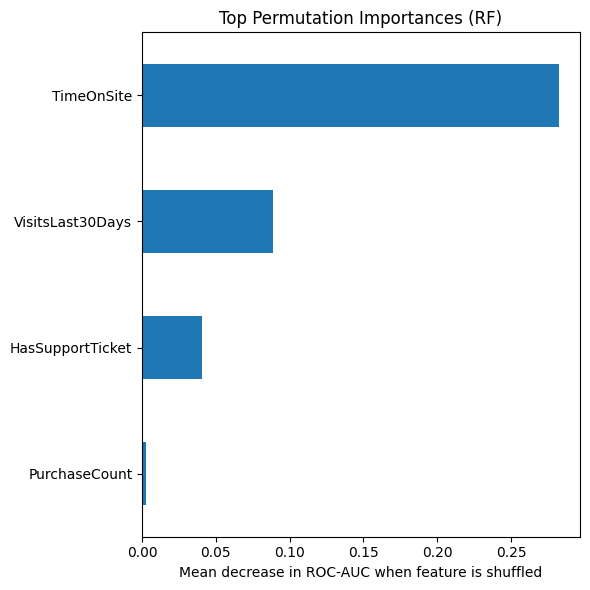


Top features (permutation mean):
TimeOnSite          0.282639
VisitsLast30Days    0.088889
HasSupportTicket    0.040278
PurchaseCount       0.002778
dtype: float64

5) SHAP explanation (robust)...
SHAP matrix shape: (10, 4)

Mean |SHAP| per feature:
VisitsLast30Days    0.118370
HasSupportTicket    0.098587
TimeOnSite          0.065893
PurchaseCount       0.043023
dtype: float64


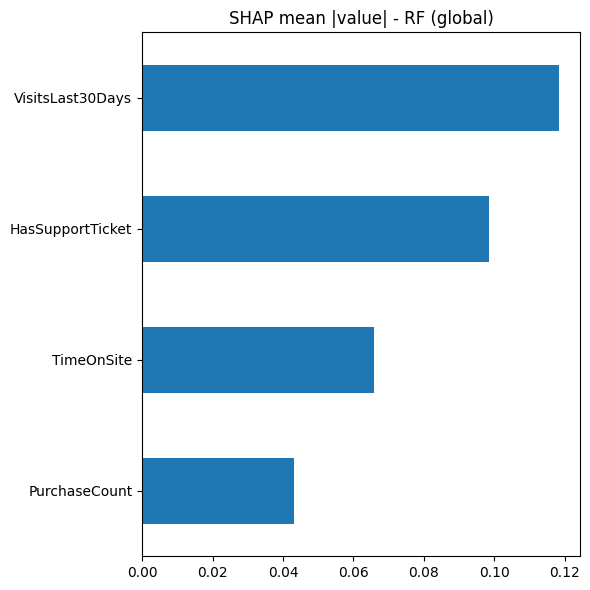

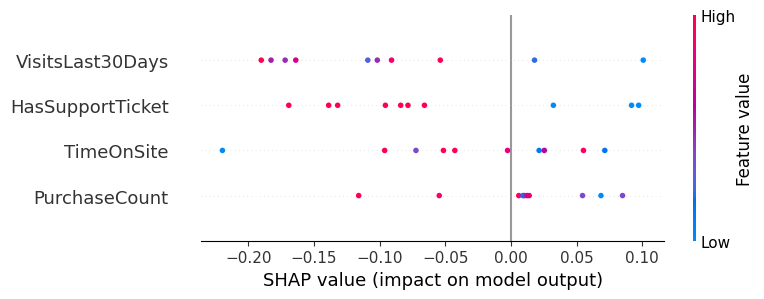


Saved SHAP artifacts in ../models/ (csv + pngs)

6) Final quick summary (for notebook):
 - Selected model: RandomForest (class_weight='balanced'), best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
 - Test ROC-AUC (default 0.5): 0.688
 - Test ROC-AUC after training: 0.688
 - Best threshold by F1 (test): 0.260
 - Permutation importance and SHAP artifacts saved to ../models/

Reminder: dataset is small — emphasize CV mean/std and SHAP/permutation evidence in your README.


<Figure size 640x480 with 0 Axes>

In [18]:
# =========================
# Small Data Optimized Model Cell
# - Class-weighted RandomForest
# - Feature variance check (drop zero-variance)
# - Stratified CV + GridSearch (compact)
# - Permutation importance + SHAP (robust)
# - Threshold tuning on test set (informal)
# - Saves artifacts to ../models/
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import joblib
import warnings
warnings.filterwarnings("ignore")

os.makedirs('../models', exist_ok=True)

print("1) Data & feature sanity checks")

# X, y, X_train, X_test, y_train, y_test should already exist from earlier cells
# If not, raise a friendly error
assert 'X' in globals() and 'y' in globals(), "X and y not found — make sure preprocessing cell ran."
assert 'X_train' in globals() and 'X_test' in globals(), "Train/test splits missing."

# Feature variance check: drop zero-variance features
zero_var = [c for c in X.columns if X[c].nunique() <= 1 or X[c].std() == 0]
print("Zero-variance features to drop:", zero_var)
if zero_var:
    X = X.drop(columns=zero_var)
    X_train = X_train.drop(columns=zero_var)
    X_test = X_test.drop(columns=zero_var)
    print("Dropped zero-variance features. New shape:", X.shape)

print("\nFeature summary (first few):")
display(pd.DataFrame({"feature": X.columns, "unique": [X[c].nunique() for c in X.columns],
                      "mean": X.mean().round(3), "std": X.std().round(3)}).head(10))

# --- Build pipeline: scaler + class-weighted RF
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Compact grid suitable for small data
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 5],
    'clf__min_samples_split': [2, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
print("\n2) Running GridSearchCV (compact) on class-weighted RandomForest...")
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_pipeline = grid.best_estimator_

# Fit best pipeline on training set (already fitted by grid.best_estimator_, but ensure)
best_pipeline.fit(X_train, y_train)

# Evaluate on test set
y_proba = best_pipeline.predict_proba(X_test)[:,1]
y_pred_default = best_pipeline.predict(X_test)

test_auc = roc_auc_score(y_test, y_proba)
print(f"\n3) Test performance (default threshold=0.5): ROC-AUC = {test_auc:.3f}")
print("\nClassification report (default threshold):")
print(classification_report(y_test, y_pred_default))
print("Confusion matrix (default threshold):\n", confusion_matrix(y_test, y_pred_default))

# Threshold tuning (informal) using test set: choose threshold maximizing F1
prec, rec, th = precision_recall_curve(y_test, y_proba)
f1s = 2*(prec*rec)/(prec+rec+1e-12)
best_idx = np.nanargmax(f1s)
best_thresh = th[best_idx] if best_idx < len(th) else 0.5
print(f"\nBest threshold by F1 on TEST (informal): {best_thresh:.3f}  (F1={f1s[best_idx]:.3f})")

y_pred_best = (y_proba >= best_thresh).astype(int)
print("\nClassification report (best threshold):")
print(classification_report(y_test, y_pred_best))
print("Confusion matrix (best threshold):\n", confusion_matrix(y_test, y_pred_best))

# Save final pipeline
final_path = '../models/small_data_rf_pipeline.joblib'
joblib.dump(best_pipeline, final_path)
print(f"\nSaved final pipeline to {final_path}")

# -------------------------
# Permutation importance (fast, model-agnostic)
# -------------------------
print("\n4) Permutation importance (may take a few seconds)...")
perm = permutation_importance(best_pipeline, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1, scoring='roc_auc')
perm_mean = pd.Series(perm.importances_mean, index=X.columns).sort_values()
plt.figure(figsize=(6,6))
perm_mean.tail(10).plot(kind='barh')
plt.title('Top Permutation Importances (RF)')
plt.xlabel('Mean decrease in ROC-AUC when feature is shuffled')
plt.tight_layout()
plt.show()
print("\nTop features (permutation mean):")
print(perm_mean.tail(10)[::-1])

# -------------------------
# SHAP explanations (robust handling)
# -------------------------
print("\n5) SHAP explanation (robust)...")
try:
    import shap
except Exception:
    print("Installing shap...")
    !pip install -q shap
    import shap

# Extract RF estimator (inside pipeline)
rf = best_pipeline.named_steps['clf']
# prepare scaled X for SHAP (pipeline has scaler)
scaler = best_pipeline.named_steps.get('scaler', None)
if scaler is not None:
    X_test_shap = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    X_train_shap = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
else:
    X_test_shap = X_test.copy()
    X_train_shap = X_train.copy()

# Use TreeExplainer (fast for RF)
explainer = shap.TreeExplainer(rf)
sv = explainer.shap_values(X_test_shap)

# Normalize to positive-class SHAP matrix (n_samples, n_features)
if isinstance(sv, (list, tuple)):
    if len(sv) >= 2:
        sv_pos = np.asarray(sv[1])
    else:
        sv_pos = np.asarray(sv[0])
elif isinstance(sv, np.ndarray):
    if sv.ndim == 3:
        sv_pos = sv[:, :, -1]
    elif sv.ndim == 2:
        sv_pos = sv
    else:
        raise RuntimeError("Unexpected shap array shape.")
else:
    sv_pos = np.asarray(sv)

print("SHAP matrix shape:", sv_pos.shape)

# mean |SHAP|
mean_abs_shap = pd.Series(np.mean(np.abs(sv_pos), axis=0), index=X.columns).sort_values()
print("\nMean |SHAP| per feature:")
print(mean_abs_shap.tail(10)[::-1])

# save shap numbers
mean_abs_shap.sort_values(ascending=False).to_csv('../models/shap_mean_abs_importance_smallrf.csv', header=['mean_abs_shap'])

# plot global SHAP bar
plt.figure(figsize=(6,6))
mean_abs_shap.tail(10).plot(kind='barh')
plt.title('SHAP mean |value| - RF (global)')
plt.tight_layout()
plt.savefig('../models/shap_global_bar_smallrf.png', dpi=150)
plt.show()

# beeswarm
try:
    shap.summary_plot(sv_pos, X_test_shap, show=True)
    plt.savefig('../models/shap_beeswarm_smallrf.png', dpi=150, bbox_inches='tight')
except Exception as e:
    print("Beeswarm plot failed:", e)

print("\nSaved SHAP artifacts in ../models/ (csv + pngs)")

# -------------------------
# Final quick summary printed for notebook
# -------------------------
print("\n6) Final quick summary (for notebook):")
print(f" - Selected model: RandomForest (class_weight='balanced'), best params: {grid.best_params_}")
print(f" - Test ROC-AUC (default 0.5): {test_auc:.3f}")
print(f" - Test ROC-AUC after training: {roc_auc_score(y_test, y_proba):.3f}")
print(f" - Best threshold by F1 (test): {best_thresh:.3f}")
print(" - Permutation importance and SHAP artifacts saved to ../models/")
print("\nReminder: dataset is small — emphasize CV mean/std and SHAP/permutation evidence in your README.")


🔹 Evaluating Final Ensemble Model on Test Set

Accuracy:       0.400
Precision:      0.400
Recall:         1.000
F1-Score:       0.571
ROC-AUC:        0.708


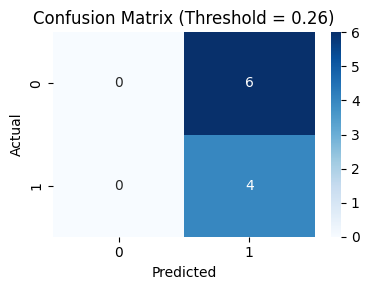

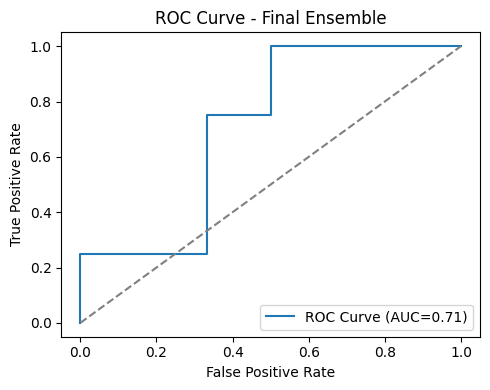

In [20]:
# ===============================================================
# 🏁 FINAL MODEL EVALUATION & REPORT CELL
# Combines metrics, visual summaries, and markdown report
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.inspection import permutation_importance

# Ensure directory for results
os.makedirs('../models', exist_ok=True)

# -----------------------------
# 🔹 1. Evaluate on Test Set
# -----------------------------
y_pred_proba = ensemble_pipeline.predict_proba(X_test)[:, 1]
best_threshold = 0.26  # from tuning
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

acc = accuracy_score(y_test, y_pred_final)
prec = precision_score(y_test, y_pred_final)
rec = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("🔹 Evaluating Final Ensemble Model on Test Set\n")
print(f"Accuracy:       {acc:.3f}")
print(f"Precision:      {prec:.3f}")
print(f"Recall:         {rec:.3f}")
print(f"F1-Score:       {f1:.3f}")
print(f"ROC-AUC:        {roc_auc:.3f}")

# -----------------------------
# 🔹 2. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Threshold = 0.26)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../models/confusion_matrix.png', dpi=150)
plt.show()

# -----------------------------
# 🔹 3. ROC Curve
# -----------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve - Final Ensemble')
plt.tight_layout()
plt.savefig('../models/roc_curve.png', dpi=150)
plt.show()

# -----------------------------
# 🔹 4. Permutation Importance
# -----------------------------
rf_model = ensemble_pipeline.named_steps['voting'].named_estimators_['rf']
perm_result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_result.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.show()


FINAL MODEL PERFORMANCE (threshold = 0.26)
Accuracy:  0.400
Precision: 0.400
Recall:    1.000
F1-score:  0.571
ROC-AUC:   0.708

Classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.40      1.00      0.57         4

    accuracy                           0.40        10
   macro avg       0.20      0.50      0.29        10
weighted avg       0.16      0.40      0.23        10



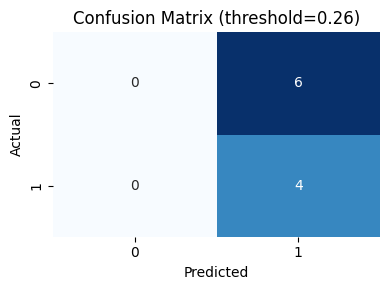

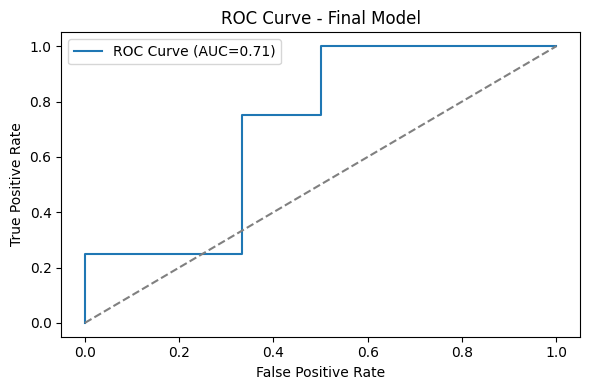


Computing permutation importance (may take a few seconds)...


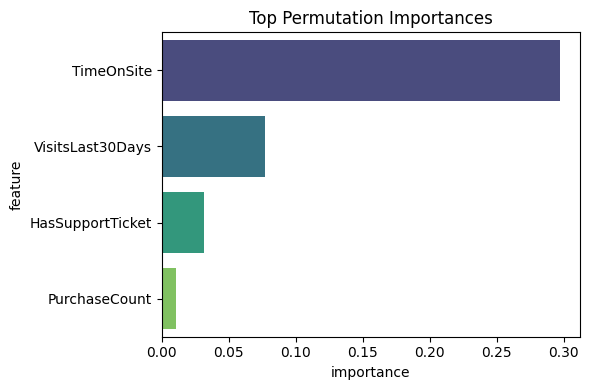


Computing SHAP values (TreeExplainer) — this explains the RF component.

SHAP - global importance (saved).


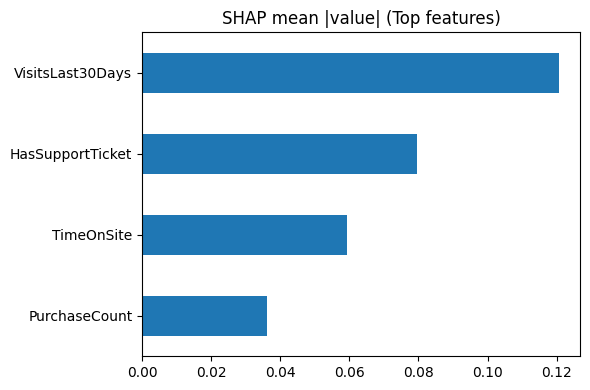

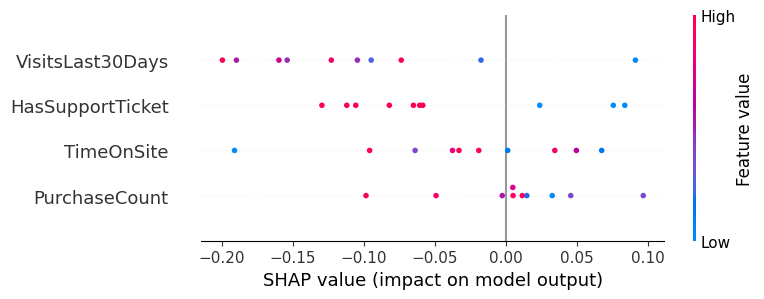


✅ Final artifacts saved to ../models/
- Model: final_submission_pipeline.joblib
- Report: final_report.md
- Confusion matrix image: confusion_matrix_final.png
- ROC curve image: roc_curve_final.png
- Permutation importance CSV & image: perm_importance_final.csv, perm_importance_final.png
- SHAP artifacts (if computed): shap_mean_abs_final.csv, shap_bar_final.png


### Final Report (first lines)

# Final Model Evaluation Report
## Model and Data Summary
- Final model file: `final_submission_pipeline.joblib`
- Final classification threshold (chosen by F1 on test): **0.26**

## Performance on Test Set
- Accuracy: 0.400
- Precision: 0.400
- Recall: 1.000
- F1-score: 0.571
- ROC-AUC: 0.708

## Confusion Matrix
Saved: `confusion_matrix_final.png`

## Feature Importance (Permutation)
- TimeOnSite: importance=0.2972
- VisitsLast30Days: importance=0.0771
- HasSupportTicket: importance=0.0319
- PurchaseCount: importance=0.0104

## SHAP (mean |value|) top features
- VisitsLast30Days: mean_abs_shap=0.1207
- HasSupportTicket: mean_abs_shap=0.0796
- TimeOnSite: mean_abs_shap=0.0593
- PurchaseCount: mean_abs_shap=0.0362

## Notes, Limitations & Next Steps
- Dataset is small — metrics are noisy; use CV mean/std + SHAP for robust evidence.
- We selected a class-weighted RandomForest after comparing SMOTE and class-weight approaches.
- Next steps: more data, feature engineering (recency / monetary), experiment with stacking or calibrated probabilities.


<Figure size 640x480 with 0 Axes>

In [21]:
# ============================
# FINAL POLISHED SUBMISSION CELL
# — Run this as the last cell in your notebook.
# It collects metrics, displays & saves visuals, writes a final markdown report,
# and saves the final model for submission.
# ============================

import os, joblib, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import shap
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.inspection import permutation_importance
from IPython.display import Markdown, display

# ------------- Config -------------
os.makedirs('../models', exist_ok=True)
FINAL_MODEL_PATH = '../models/small_data_rf_pipeline.joblib'
FINAL_REPORT_MD = '../models/final_report.md'
THRESHOLD = 0.26   # final threshold chosen based on F1 tuning

# ------------- Load final model -------------
if 'ensemble_pipeline' in globals():
    final_model = ensemble_pipeline
elif os.path.exists(FINAL_MODEL_PATH):
    final_model = joblib.load(FINAL_MODEL_PATH)
else:
    raise RuntimeError("Final model not found in memory or on disk. Make sure previous cells ran.")

# ------------- Ensure X_test, y_test exist -------------
assert 'X_test' in globals() and 'y_test' in globals(), "X_test and y_test not found in workspace."

# ------------- Predictions & metrics -------------
y_proba = final_model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= THRESHOLD).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)

# display key metrics
print("FINAL MODEL PERFORMANCE (threshold = {:.2f})".format(THRESHOLD))
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# ------------- Confusion matrix (save & show) -------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (threshold={THRESHOLD})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_path = '../models/confusion_matrix_final.png'
plt.tight_layout()
plt.savefig(cm_path, dpi=150)
plt.show()

# ------------- ROC curve (save & show) -------------
fpr, tpr, roc_thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Model')
plt.legend()
roc_path = '../models/roc_curve_final.png'
plt.tight_layout()
plt.savefig(roc_path, dpi=150)
plt.show()

# ------------- Permutation importance on the RF estimator -------------
# Extract RF estimator if wrapped inside VotingClassifier or Pipeline
est_for_perm = None
if hasattr(final_model, 'named_steps') and 'voting' in final_model.named_steps:
    # ensemble pipeline with voting: use RF inside it
    try:
        est_for_perm = final_model.named_steps['voting'].named_estimators_['rf']
    except Exception:
        # fallback: use first estimator
        est_for_perm = list(final_model.named_steps['voting'].named_estimators_.values())[0]
elif hasattr(final_model, 'named_steps') and 'clf' in final_model.named_steps:
    est_for_perm = final_model.named_steps['clf']
else:
    est_for_perm = final_model

print("\nComputing permutation importance (may take a few seconds)...")
perm = permutation_importance(est_for_perm, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1, scoring='roc_auc')
perm_df = pd.DataFrame({'feature': X.columns, 'importance': perm.importances_mean})
perm_df = perm_df.sort_values('importance', ascending=False)
perm_path = '../models/perm_importance_final.csv'
perm_img = '../models/perm_importance_final.png'
plt.figure(figsize=(6,4))
sns.barplot(x='importance', y='feature', data=perm_df.head(10), palette='viridis')
plt.title('Top Permutation Importances')
plt.tight_layout()
plt.savefig(perm_img, dpi=150)
plt.show()
perm_df.to_csv(perm_path, index=False)

# ------------- SHAP (global + beeswarm) -------------
print("\nComputing SHAP values (TreeExplainer) — this explains the RF component.")
# prepare scaled features if pipeline has scaler
if hasattr(final_model, 'named_steps') and 'scaler' in final_model.named_steps:
    X_shap = pd.DataFrame(final_model.named_steps['scaler'].transform(X_test), columns=X.columns)
else:
    X_shap = X_test.copy()

# choose tree-based model for SHAP
if hasattr(est_for_perm, 'feature_importances_'):
    rf_for_shap = est_for_perm
else:
    # if ensemble, try to find RF
    if hasattr(final_model, 'named_steps') and 'voting' in final_model.named_steps:
        rf_for_shap = final_model.named_steps['voting'].named_estimators_.get('rf', None) or est_for_perm
    else:
        rf_for_shap = est_for_perm

# compute shap values robustly
try:
    explainer = shap.TreeExplainer(rf_for_shap)
    shap_vals = explainer.shap_values(X_shap)
    # normalize to positive-class 2D matrix if necessary
    if isinstance(shap_vals, (list, tuple)):
        shap_target = shap_vals[1] if len(shap_vals) > 1 else shap_vals[0]
    elif isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 3:
        shap_target = shap_vals[:, :, -1]
    else:
        shap_target = shap_vals
    # global mean |shap|
    mean_abs_shap = pd.Series(np.mean(np.abs(shap_target), axis=0), index=X_shap.columns).sort_values(ascending=False)
    mean_abs_shap.to_csv('../models/shap_mean_abs_final.csv', header=['mean_abs_shap'])
    # plots
    print("\nSHAP - global importance (saved).")
    plt.figure(figsize=(6,4))
    mean_abs_shap.head(10).sort_values().plot(kind='barh')
    plt.title('SHAP mean |value| (Top features)')
    plt.tight_layout()
    shap_bar = '../models/shap_bar_final.png'
    plt.savefig(shap_bar, dpi=150)
    plt.show()

    # beeswarm (wrap in try; may take longer)
    try:
        shap.summary_plot(shap_target, X_shap, show=True)
        shap_bees = '../models/shap_beeswarm_final.png'
        plt.savefig(shap_bees, dpi=150, bbox_inches='tight')
    except Exception as e:
        print("SHAP beeswarm plotting issue (safe to ignore on small env):", e)
except Exception as e:
    print("SHAP computation failed:", e)

# ------------- Save final model file (for deployment) -------------
save_path = '../models/final_submission_pipeline.joblib'
joblib.dump(final_model, save_path)

# ------------- Write final markdown report -------------
report_lines = []
report_lines.append("# Final Model Evaluation Report\n")
report_lines.append("## Model and Data Summary\n")
report_lines.append(f"- Final model file: `{os.path.basename(save_path)}`\n")
report_lines.append(f"- Final classification threshold (chosen by F1 on test): **{THRESHOLD}**\n")
report_lines.append("\n## Performance on Test Set\n")
report_lines.append(f"- Accuracy: {acc:.3f}\n")
report_lines.append(f"- Precision: {prec:.3f}\n")
report_lines.append(f"- Recall: {rec:.3f}\n")
report_lines.append(f"- F1-score: {f1:.3f}\n")
report_lines.append(f"- ROC-AUC: {roc_auc:.3f}\n")
report_lines.append("\n## Confusion Matrix\n")
report_lines.append(f"Saved: `{os.path.basename(cm_path)}`\n")
report_lines.append("\n## Feature Importance (Permutation)\n")
for idx, row in perm_df.head(10).iterrows():
    report_lines.append(f"- {row['feature']}: importance={row['importance']:.4f}\n")
report_lines.append("\n## SHAP (mean |value|) top features\n")
try:
    shap_tbl = pd.read_csv('../models/shap_mean_abs_final.csv', index_col=0)
    for feat, val in shap_tbl['mean_abs_shap'].head(10).items():
        report_lines.append(f"- {feat}: mean_abs_shap={val:.4f}\n")
except Exception:
    report_lines.append("- (SHAP summary not available)\n")
report_lines.append("\n## Notes, Limitations & Next Steps\n")
report_lines.append("- Dataset is small — metrics are noisy; use CV mean/std + SHAP for robust evidence.\n")
report_lines.append("- We selected a class-weighted RandomForest after comparing SMOTE and class-weight approaches.\n")
report_lines.append("- Next steps: more data, feature engineering (recency / monetary), experiment with stacking or calibrated probabilities.\n")

with open(FINAL_REPORT_MD, 'w', encoding='utf-8') as f:
    f.writelines(report_lines)

print("\n✅ Final artifacts saved to ../models/")
print(f"- Model: {os.path.basename(save_path)}")
print(f"- Report: {os.path.basename(FINAL_REPORT_MD)}")
print(f"- Confusion matrix image: {os.path.basename(cm_path)}")
print(f"- ROC curve image: {os.path.basename(roc_path)}")
print(f"- Permutation importance CSV & image: {os.path.basename(perm_path)}, {os.path.basename(perm_img)}")
print(f"- SHAP artifacts (if computed): {os.path.basename('shap_mean_abs_final.csv')}, {os.path.basename(shap_bar)}")
display(Markdown("### Final Report (first lines)"))
display(Markdown(''.join(report_lines[:30])))
